In [1]:
%%capture
import matplotlib.pyplot as plt
import jax
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

try:
    from tinygp import kernels, GaussianProcess
except:
    %pip install tinygp
    from tinygp import kernels, GaussianProcess

try:
    import optax
except:
    %pip install optax
    import optax

In [2]:
# import os;os.environ['LATEXIFY'] = '';os.environ['FIG_DIR'] = 'figures'

In [3]:
pml.latexify(width_scale_factor=2, fig_height=1.5)
if pml.is_latexify_enabled():
    plt.rcParams["lines.markersize"] = 3

## Data

In [4]:
temperature_data = pd.read_csv(
    "https://raw.githubusercontent.com/probml/probml-data/main/data/moteData/intel_lab_temperature.csv.tar.gz"
)

In [5]:
data = temperature_data.set_index("Date")
data = data["2004-02-28":"2004-02-28"]
data = data.groupby("ID").agg("mean")
data.columns

Index(['Epoch', 'Temp', 'Humidity', 'Light', 'Voltage', 'X', 'Y'], dtype='object')

In [6]:
data["X"] = StandardScaler().fit_transform(data["X"].values.reshape(-1, 1))
data["Y"] = StandardScaler().fit_transform(data["Y"].values.reshape(-1, 1))
data["Temp"] = StandardScaler().fit_transform(data["Temp"].values.reshape(-1, 1))

In [7]:
seed = jax.random.PRNGKey(1)
idx = jax.random.choice(seed, len(data), (10,), replace=False)
initial_data = data.iloc[idx]

x_initial = initial_data[["X", "Y"]].values
y_initial = initial_data["Temp"].values
x_initial.shape, y_initial.shape

((10, 2), (10,))

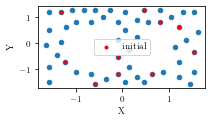

In [8]:
data.plot("X", "Y", kind="scatter")
plt.scatter(x_initial[:, 0], x_initial[:, 1], label="initial", color="red")
plt.legend();

## GP Model

In [9]:
@jax.tree_util.register_pytree_node_class
class GPModel:
    def __init__(self, log_var, log_scale, log_noise_var, mean):
        self.log_var = log_var
        self.log_scale = log_scale
        self.log_noise_var = log_noise_var
        self.mean = mean

    def get_gp(self, x_initial):
        kernel = jnp.exp(self.log_var) * kernels.ExpSquared(scale=jnp.exp(self.log_scale))
        gp = GaussianProcess(kernel, x_initial, diag=jnp.exp(self.log_noise_var), mean=self.mean)
        return gp

    def tree_flatten(self):
        return (self.log_var, self.log_scale, self.log_noise_var, self.mean), None

    def tree_unflatten(self, values, **kwargs):
        return GPModel(*values)

## initialing

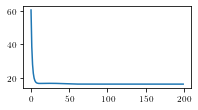

In [10]:
def loss_fn(model, x, y):
    gp = model.get_gp(x_initial=x)
    return -gp.log_probability(y)


value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))

n_iters = 200
tx = optax.adam(learning_rate=0.1)

model = GPModel(log_var=jnp.log(1.0), log_scale=jnp.log(1.0), log_noise_var=jnp.array(-10.0), mean=0.0)
state = tx.init(model)

losses = []
for i in range(n_iters):
    loss, grads = value_and_grad_fn(model, x_initial, y_initial)
    losses.append(loss)
    updates, state = tx.update(grads, state)
    model = optax.apply_updates(model, updates)

plt.plot(losses);

## Inference

In [11]:
def get_entropy(gp, y_initial, x_test):
    gp = model.get_gp(x_initial)
    pred_gp = gp.condition(y_initial, x_test).gp
    return pred_gp.variance.reshape(N, N)


def get_mi(gp, y_initial, x_test):
    gp = model.get_gp(x_initial)
    pred_gp = gp.condition(y_initial, x_test).gp
    variance = pred_gp.variance
    post_cov = gp.kernel(x_test, x_test) + jnp.eye(x_test.shape[0]) * 0.001
    chol = jnp.linalg.cholesky(post_cov)
    inv_chol = jnp.linalg.inv(chol)
    inv = inv_chol.T @ inv_chol
    return (variance * jnp.diag(inv)).reshape(N, N)

In [12]:
N = 30
x1 = jnp.linspace(data["X"].min() - 1.0, data["X"].max() + 1.0, N)
x2 = jnp.linspace(data["Y"].min() - 0.5, data["Y"].max() + 2.0, N)
X1, X2 = jnp.meshgrid(x1, x2)
x_test = jnp.array([(xi, xj) for xi, xj in zip(X1.flatten(), X2.flatten())])
gp = model.get_gp(x_initial)

entropy = get_entropy(gp, y_initial, x_test)
mi = get_mi(gp, y_initial, x_test)

In [19]:
def plot_it(method):
    if method == "MI":
        acquisition = mi
        addx, addy = 0, 0
    else:
        acquisition = entropy
        addx = 0.2
        addy = 0.2
    chosen_idx = acquisition.ravel().argmax()
    chosen_x1 = X1.ravel()[chosen_idx]
    chosen_x2 = X2.ravel()[chosen_idx]

    plt.figure()
    plt.scatter(x_initial[:, 0], x_initial[:, 1], color="k")
    plt.scatter(chosen_x1 + addx, chosen_x2 + addy, s=10, c="r", label=f"maximum {method}", zorder=10)
    plt.contourf(X1, X2, acquisition, alpha=0.5, levels=10)
    plt.colorbar(label=method)
    plt.legend(loc="upper left")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    pml.savefig(f"sensor_placements_{method}")

saving image to figures/sensor_placements_Entropy_latexified.pdf
Figure size: [3.  1.5]


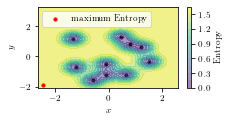

In [20]:
plot_it("Entropy")

saving image to figures/sensor_placements_MI_latexified.pdf
Figure size: [3.  1.5]


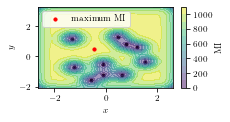

In [21]:
plot_it("MI")